for more scope creep, using a 30 (or 60 or 90) day price plot estimate the most likley day that the stock will peak and use this as the sell date.


In [1]:
import sys
print(sys.executable)

c:\Users\aaron\OneDrive\Documents\Programming\Python\TradingBot\botenv\Scripts\python.exe


In [2]:
import pandas as pd
#import pandas_datareader as pdr
from datetime import datetime, timedelta, time
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from alpha_vantage.techindicators import TechIndicators
from pandas.tseries.offsets import BMonthEnd
from dotenv import load_dotenv
import os
import talib
#import tensorflow as tf
import itertools
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix # Loading required libraries

#load_dotenv()
#ALPHA_V_API_KEY = os.getenv('ALPHA_V_API_KEY')

In [3]:
df = pd.read_csv('data/insider_trades.csv', parse_dates=['transaction_date', 'trade_date'])
df = df.dropna()

for i in ['last_price', 'Qty', 'shares_held', 'Owned', 'Value']:
    df[i] = (
        df[i]
        .astype(str)
        .str.replace('New', '1000000000', regex=False)
        .str.replace('[\$,\+\-\%>]', '', regex=True)
        .astype(float)
    )

df['transaction_date'] = pd.to_datetime(df['transaction_date'], format="%d/%m/%Y %H:%M")
df['trade_date'] = pd.to_datetime(df['trade_date'])

#print(type(df['transaction_date']))
#print(df['transaction_date'])
#print(df['trade_date'])

df['Owned_norm'] = 1 - np.exp(-df['Owned']*np.log(2)/100)

df = df.sort_values(by='transaction_date')

df = df.loc[:499]


C:\Users\aaron\AppData\Local\Temp\ipykernel_2548\569921546.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('data/insider_trades.csv', parse_dates=['transaction_date', 'trade_date'])


#### you can look at the recommendations by analysts

### Grouping tickers

Ticker	Company Name	Unique Buyers	Total Purchases	Positions Represented

#### my first attempt Somewhat trash

In [4]:
df_by_ticker = pd.DataFrame(columns=['transaction_date', 'ticker', 'company_name', 'unique_buyers', 'total_purchases', 'Title', 'owner_names'])

#We can assume that each row we add here is completely new, and that double insider buys are caught by the func below
#44 as an example
trade_index = 44
trade = df.iloc[trade_index]

new_row = {
    'transaction_date': trade['transaction_date'],
    'ticker': trade['ticker'],
    'company_name': trade['company_name'],
    'unique_buyers': 1,
    'total_purchases': 1,
    'Title': [trade['Title']],
    'owner_names': [trade['owner_name']]
}

df_by_ticker.loc[len(df_by_ticker)] = new_row

print(df_by_ticker)

     transaction_date ticker        company_name  unique_buyers  \
0 2024-07-02 09:54:00   ISBA  Isabella Bank Corp              1   

   total_purchases                   Title     owner_names  
0                1  [Chief Credit Officer]  [Catlin Jon D]  


In [5]:
print(df_by_ticker.iloc[-1])

transaction_date       2024-07-02 09:54:00
ticker                                ISBA
company_name            Isabella Bank Corp
unique_buyers                            1
total_purchases                          1
Title               [Chief Credit Officer]
owner_names                 [Catlin Jon D]
Name: 0, dtype: object


In [6]:
indexs = pd.Series()
for i in range(len(df)):
    indexs[i] = i



# for grouping trades that have the same ticker symbol (that are made within 2 days of eachother)
#assume the earliest trade is given first, only furture trades need to be checked.


transaction_date = df['transaction_date'].iloc[44]
cutoff_date = transaction_date + timedelta(days=2)


for i in range(trade_index + 1, len(indexs)+1):
    if df['transaction_date'].iloc[i] > cutoff_date:
        print('out of date range; break')
        break
    
    if df['ticker'].iloc[i] != df_by_ticker['ticker'].iloc[-1]:
        print('non matching ticker; continue')
        continue
    
    if i not in indexs:
        print('Index already used; continue')
        continue
    
    #if passes the above two conditions then i want to:
    #add 1 to total purchases
    #check if it is a unique buy
    #if yes, add the name to a list and title to a list

    print('trade to be added:')
    print(df.iloc[i])

    df_by_ticker['total_purchases'].iloc[-1] = df_by_ticker['total_purchases'].iloc[-1] + 1

    if df.loc[i, 'owner_name'] not in df_by_ticker['owner_names'].iloc[-1]:
        df_by_ticker['owner_names'].iloc[-1].append(df['owner_name'].iloc[i])
        #df_by_ticker.at[-1, 'owner_names'].append(df['owner_name'].iloc[i]) if above no work use this.
        df_by_ticker['unique_buyers'].iloc[-1] = df_by_ticker['unique_buyers'].iloc[-1] + 1

        if df['Title'].iloc[i] not in df_by_ticker['Title'].iloc[-1]:
                df_by_ticker['Title'].iloc[-1].append(df['Title'].iloc[i])
                #df_by_ticker.at[-1, 'owner_name'].append(df['owner_name'].iloc[i]) if above no work use this.
    
    del(indexs[i])


    


trade to be added:
transaction_date         2024-07-02 09:54:00
trade_date               2024-07-01 00:00:00
ticker                                  ISBA
company_name              Isabella Bank Corp
owner_name                     Wheeler Peggy
Title               Chief Operations Officer
transaction_type                P - Purchase
last_price                             17.29
Qty                                     29.0
shares_held                           8549.0
Owned                                    0.0
Value                                  500.0
Owned_norm                               0.0
Name: 45, dtype: object
trade to be added:
transaction_date    2024-07-02 09:54:00
trade_date          2024-07-01 00:00:00
ticker                             ISBA
company_name         Isabella Bank Corp
owner_name           Schaefer William M
Title                               CFO
transaction_type           P - Purchase
last_price                        17.29
Qty                              

C:\Users\aaron\AppData\Local\Temp\ipykernel_2548\1623414342.py:36: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_by_ticker['total_purchases'].iloc[-1] = df_by_ticker['total_purchases'].iloc[-1] + 1
C:\Users\aaron\AppData\Local\Temp\ipyker

In [7]:
df_by_ticker

,transaction_date,ticker,company_name,unique_buyers,total_purchases,Title,owner_names
0,2024-07-02 09:54:00,ISBA,Isabella Bank Corp,4,4,"[Chief Credit Officer, Chief Operations Office...","[Catlin Jon D, Wheeler Peggy, Schaefer William..."


#### Improved grouping.

1: Instead of looping from index i to index j where j has date i plus two days, a mask is used with a date and ticker condition.

2: Instead of using a pd series for used indexs, a set() was added to by taking the .index list from the masked pd df (group_df).

3: The unique_buyers and all_titles were created by taking sets of the cols of group_df.

4: A dict was then created with the *final* numbers and then added to the list of grouped trades, and then that list was converted to a pd df.

In [8]:


df = df.sort_values(by='transaction_date').reset_index(drop=True)
grouped = []
used_indices = set()

for idx, row in df.iterrows():
    if idx in used_indices:
        continue

    ticker = row['ticker']
    start_date = row['transaction_date']
    cutoff_date = start_date + timedelta(days=5)

    # Filter trades for this ticker within the 2-day window
    mask = (
        (df['ticker'] == ticker) &
        (df['transaction_date'] >= start_date) &
        (df['transaction_date'] <= cutoff_date)
    )
    group_df = df[mask]
    group_indices = group_df.index.tolist() 
    used_indices.update(group_indices)

    unique_buyers = set(group_df['owner_name'])
    all_titles = set(group_df['Title'])

    earliest_trade_date = group_df['trade_date'].min()

    grouped.append({
        'transaction_date': start_date,
        'trade_date': earliest_trade_date,
        'ticker': ticker,
        'company_name': row['company_name'],
        'unique_buyers': len(unique_buyers),
        'total_purchases': len(group_df),
        'Title': list(all_titles),
        'owner_names': list(unique_buyers)
    })



df_by_ticker = pd.DataFrame(grouped) #note that trade_date is the earliest transaction 
#print(df_by_ticker)

def adjust_transaction_date(dt):
    if dt.hour < 9 or (dt.hour == 9 and dt.minute < 30):
        return (dt - pd.Timedelta(days=1)).date()
    else:
        return dt.date()

df_by_ticker['eff_trans_date'] = df_by_ticker['transaction_date'].apply(adjust_transaction_date)

### Retreiving ticker prices and key metrics

Binary up down for the next day 

We want to find the percent change over the following day, 5 days, 20 days (excluding weekends).

Keep a 30 day price plot maybe for predicting 

for more scope creep, using a 30 (or 60 or 90) day price plot estimate the most likley day that the stock will peak and use this as the sell date.


In [9]:
#This was slow and trash, better to bulk download and select the 90 days after
'''
trade = df_by_ticker.iloc[1]
print(trade)
start= trade['transaction_date'].date()  - timedelta(days=91)
end = trade['transaction_date'].date() - timedelta(days=1)

ticker = yf.Ticker(trade['ticker'])
ticker_data = ticker.history(start=start, end=end)[['Open', 'High', 'Low', 'Close', 'Volume']]

def get_ticker_data_90_days(trade): #pass in row of df that incrudes the trade date and the ticker symbol
    #print(trade)
    start= trade['transaction_date'].date()  - timedelta(days=91)
    end = trade['transaction_date'].date() - timedelta(days=1)
    return yf.Ticker(trade['ticker']).history(start=start, end=end)[['Open', 'High', 'Low', 'Close', 'Volume']]


df_ticker_data = df_by_ticker.apply(lambda row: get_ticker_data_90_days(row), axis=1)
'''

"\ntrade = df_by_ticker.iloc[1]\nprint(trade)\nstart= trade['transaction_date'].date()  - timedelta(days=91)\nend = trade['transaction_date'].date() - timedelta(days=1)\n\nticker = yf.Ticker(trade['ticker'])\nticker_data = ticker.history(start=start, end=end)[['Open', 'High', 'Low', 'Close', 'Volume']]\n\ndef get_ticker_data_90_days(trade): #pass in row of df that incrudes the trade date and the ticker symbol\n    #print(trade)\n    start= trade['transaction_date'].date()  - timedelta(days=91)\n    end = trade['transaction_date'].date() - timedelta(days=1)\n    return yf.Ticker(trade['ticker']).history(start=start, end=end)[['Open', 'High', 'Low', 'Close', 'Volume']]\n\n\ndf_ticker_data = df_by_ticker.apply(lambda row: get_ticker_data_90_days(row), axis=1)\n"

#### Bulk download ticker data and then pickout the 90 day bits you need

In [10]:
tickers = df_by_ticker['ticker'].unique()

# Bulk download full date range covering all needed periods
# any missing failed downloads with still have a row but poplated with NaN's
start=df_by_ticker['eff_trans_date'].min() - timedelta(days=100)
end=df_by_ticker['eff_trans_date'].max() + timedelta(days=31)

downloaded_prices = yf.download(
    tickers=list(tickers),
    start=start,
    end=end
)[['Open', 'High', 'Low', 'Close', 'Volume']]

spy_history = yf.Ticker('SPY').history(start=start, end=end)[['Open', 'High', 'Low', 'Close', 'Volume']]

C:\Users\aaron\AppData\Local\Temp\ipykernel_2548\3451106484.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  downloaded_prices = yf.download(
[*********************100%***********************]  199 of 199 completed

17 Failed downloads:
['AWH', 'HTLF', 'NUZE', 'CPSI', 'AGR', 'ABIO', 'ELYM', 'LCLC', 'MNKTQ', 'AMSWA', 'CCTS', 'NRBO', 'PRMW', 'PTWO', 'EVBN', 'AAN']: YFTzMissingError('possibly delisted; no timezone found')
['LGF']: YFPricesMissingError('possibly delisted; no price data found  (1d 2024-03-22 -> 2024-08-30)')


In [11]:


# Slice per row from this cached dataset
def get_ticker_data_from_cache(trade):
    prev_price = downloaded_prices.loc[trade['eff_trans_date'] - timedelta(days=100):trade['eff_trans_date'], (slice(None), trade['ticker'])]
    prev_price.columns = prev_price.columns.droplevel(1)

    future_price = downloaded_prices.loc[trade['eff_trans_date']+ timedelta(days=1) : trade['eff_trans_date'] + timedelta(days=31), (slice(None), trade['ticker'])]
    future_price.columns = future_price.columns.droplevel(1)

    row = {
        'ticker': trade['ticker'],
        'prev_prices': prev_price,
        'future_prices' : future_price
    }
    return row

df_ticker_data = df_by_ticker.apply(get_ticker_data_from_cache, axis=1, result_type='expand')

df_by_ticker['prev_prices'] = df_ticker_data['prev_prices']
df_by_ticker['future_prices'] = df_ticker_data['future_prices']


In [12]:
#dellater
trade = df_by_ticker.iloc[1]
timestamp_seconds = pd.to_datetime(trade['eff_trans_date']).timestamp()
timestamp_seconds


1719705600.0

In [13]:


def create_features(trade):
    """
    ticker_data: DataFrame with OHLCV for one stock over 3 months
    Returns: Single row of engineered features:
        '1mo_return', '3mo_return', '30d_volatility', 'rsi_14', 'macd',
        'volume_zscore', 'price_vs_sma50'.
    """
    ticker_data = trade['prev_prices']

    features = {}

    features['trade_date_epoch'] = pd.to_datetime(trade['trade_date']).timestamp() # seconds since epoch
    features['eff_trans_date_epoch'] = pd.to_datetime(trade['eff_trans_date']).timestamp() 

    
    # Price returns
    features['1mo_return'] = ticker_data['Close'].iloc[-1] / ticker_data['Close'].iloc[-22] - 1
    features['3mo_return'] = ticker_data['Close'].iloc[-1] / ticker_data['Close'].iloc[-63] - 1
    
    # Volatility
    features['30d_volatility'] = ticker_data['Close'].pct_change().std() * np.sqrt(252)
    
    # Momentum indicators
    features['rsi_14'] = talib.RSI(ticker_data['Close'], timeperiod=14)[-1]
    features['macd'] = talib.MACD(ticker_data['Close'])[0][-1]  # MACD line
    
    # Volume
    features['volume_zscore'] = (
        (ticker_data['Volume'].iloc[-1] - ticker_data['Volume'].mean()) 
        / ticker_data['Volume'].std()
    )
    
    # Trend relationships
    features['price_vs_sma50'] = ticker_data['Close'].iloc[-1] / ticker_data['Close'].rolling(50).mean().iloc[-1]

    # Bool on whether the transaction was made within trading hours.
    features['is_during_market_hours'] = time(hour=9, minute=30) < trade['transaction_date'].time() < time(hour=16)

    # Day of the week the trade was made on.
    features['day_of_week'] = trade['trade_date'].dayofweek

    # Number of days between making the trade and filing with the SEC
    features['filing_lad_days'] = (trade['transaction_date']-trade['trade_date']).days

    #df_by_ticker = df_by_ticker.dropna()
    
    title_str = ''.join(trade['Title'])
    if 'CEO' in title_str:
        features['title_rank'] = 4
    elif 'C' in title_str:
        features['title_rank'] = 3
    elif 'Dir' in title_str:
        features['title_rank'] = 2
    else:
        features['title_rank'] = 1
        
    return pd.Series(features)


def flag_month_end(trade_dates):
    """Returns 1 for last 3 business days of month"""
    flags = []
    for date in trade_dates:
        month_end = BMonthEnd().rollforward(date)  # Get official month-end
        last_3_days = pd.bdate_range(end=month_end, periods=3)  # Last 3 trading days
        flags.append(1 if date in last_3_days else 0)
    return flags

features = df_by_ticker.apply(lambda trade: create_features(trade), axis=1)


# Looks at the last valid trading date on or before the transaction date.
def get_spy_return(effective_date, spy_history):
    """Returns SPY's 1-day return for the last valid trading day <= effective_date"""
    # Get all SPY dates <= effective_date
    valid_dates = spy_history.index[spy_history.index.date <= effective_date]
    
    if len(valid_dates) == 0:
        return np.nan  # No previous trading data
    
    # Take the closest trading date
    dt = valid_dates[-1]
    return (spy_history.loc[dt, 'Close'] / spy_history.loc[dt, 'Open']) - 1

df_by_ticker['SPY_1d_return'] = df_by_ticker['eff_trans_date'].apply(
    lambda x: get_spy_return(x, spy_history)
)


df_by_ticker[features.columns] = features
df_by_ticker['month_end_flag'] = flag_month_end(df_by_ticker['trade_date'])
df_by_ticker = df_by_ticker.dropna()


C:\Users\aaron\AppData\Local\Temp\ipykernel_2548\1782853896.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features['rsi_14'] = talib.RSI(ticker_data['Close'], timeperiod=14)[-1]
C:\Users\aaron\AppData\Local\Temp\ipykernel_2548\1782853896.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  features['macd'] = talib.MACD(ticker_data['Close'])[0][-1]  # MACD line
C:\Users\aaron\AppData\Local\Temp\ipykernel_2548\1782853896.py:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_chan

### Create target variable for price movement more than x%
#### True for increase, False for decrease.

In [14]:
def create_targets(prices):
    targets = {}

    targets['next_day'] = 1 < prices['Close'].iloc[0]/prices['Open'].iloc[0]
    targets['one_week'] = 1 < prices['Close'].iloc[5]/prices['Open'].iloc[0]
    targets['one_month'] = 1 < prices['Close'].iloc[20]/prices['Open'].iloc[0] #weekends not included => 1 week = 5 elements

    targets['next_day_2%'] = 1.02 < prices['Close'].iloc[0]/prices['Open'].iloc[0]
    targets['one_week_2%'] = 1.02 < prices['Close'].iloc[5]/prices['Open'].iloc[0]
    targets['one_month_2%'] = 1.02 < prices['Close'].iloc[20]/prices['Open'].iloc[0]


    targets['next_day_5%'] = 1.05 < prices['Close'].iloc[0]/prices['Open'].iloc[0]
    targets['one_week_5%'] = 1.05 < prices['Close'].iloc[5]/prices['Open'].iloc[0]
    targets['one_month_5%'] = 1.05 < prices['Close'].iloc[20]/prices['Open'].iloc[0]


    return pd.Series(targets)





targets = df_by_ticker.apply(lambda trade: create_targets(trade['future_prices']), axis=1)

In [15]:
df_by_ticker.columns

Index(['transaction_date', 'trade_date', 'ticker', 'company_name',
       'unique_buyers', 'total_purchases', 'Title', 'owner_names',
       'eff_trans_date', 'prev_prices', 'future_prices', 'SPY_1d_return',
       'trade_date_epoch', 'eff_trans_date_epoch', '1mo_return', '3mo_return',
       '30d_volatility', 'rsi_14', 'macd', 'volume_zscore', 'price_vs_sma50',
       'is_during_market_hours', 'day_of_week', 'filing_lad_days',
       'title_rank', 'month_end_flag'],
      dtype='object')

## prediction 1 day higher (1) lower (0) price movements 


### (think about making that higher or lower than a x% increase, whatever the cut off is)

1. Binomial Logistic Regression (Good Baseline): An issue with this is that not all variables will be linearly independant. Good to get as many finacial ratios and indicators leading up to the purchase. But still do real basic analysis.

2. Random Forest: better for nonlin relationships, machine learning supervised classification modele.

****** 3. XGBoost is best "XGBoost with well-engineered features outperforms both binomial regression and deep learning in production.", best with tabular data. Min samples 5k, ideal >50k sample.

4. LSTM, for time series data (price data leading up to the date of purchase.) clean data, GPU resources, >50,000 samples required



#### To be added
days_since_earnings

Sector_ETF_5d_trend

VIX_level

This could be good to put in as well only if the filing_lag_days has some significance:

```
df['urgent_filing'] = (df['filing_lag_days'] <= 1).astype(int)  # Binary flag
df['lag_x_volume'] = df['filing_lag_days'] * df['trade_volume']  # Interaction term
```

#### GPT bullhsit you could add but i can't be bothered rn

### **1. Insider-Specific Features**
1. **`insider_cluster_size`**  
   - Number of unique insiders trading the same stock within 5 days  
   ```python
   df['insider_cluster_size'] = df.groupby(['ticker', pd.Grouper(key='trade_date', freq='5D')])['owner_names'].transform('nunique')
   ```

2. **`title_rank`**  
   - Numeric hierarchy of insider titles (CEO=4, CFO=3, Director=2, Other=1)  
   ```python
   title_rank = {'CEO':4, 'CFO':3, 'Director':2}
   df['title_rank'] = df['Title'].map(title_rank).fillna(1)
   ```

---

### **2. Advanced Market Context**
3. **`sector_relative_strength`**  
   - Stock's 5-day return vs sector ETF (e.g., XLK for tech)  
   ```python
   df['sector_relative_strength'] = df['1mo_return'] - sector_etf_returns
   ```

4. **`vix_1d_change`**  
   - Daily % change in VIX (volatility spike indicator)  
   ```python
   df['vix_1d_change'] = vix_data['Close'].pct_change().loc[df['eff_trans_date']].values
   ```

---

### **3. Technical Enhancements**
5. **`atr_14`**  
   - Average True Range (volatility normalization)  
   ```python
   df['atr_14'] = talib.ATR(df['High'], df['Low'], df['Close'], 14)
   ```

6. **`obv_5d`**  
   - 5-day On-Balance Volume trend  
   ```python
   df['obv_5d'] = talib.OBV(df['Close'], df['Volume']).pct_change(5)
   ```

---

### **4. Behavioral Signals**
7. **`short_interest_ratio`**  
   - Short interest / float (squeeze potential)  
   ```python
   df['short_interest_ratio'] = df['ticker'].map(short_interest_data)
   ```

8. **`earnings_proximity`**  
   - Days until next earnings (-30 to +30, 0=earnings day)  
   ```python
   df['earnings_proximity'] = (earnings_dates - df['trade_date']).dt.days
   ```

---

### **5. Risk Management**
9. **`beta_1mo`**  
   - Stock's 1-month beta to SPY  
   ```python
   df['beta_1mo'] = df['ticker'].map(beta_calculations)
   ```

10. **`liquidity_zscore`**  
    - Current volume vs 3-month avg (z-score)  
    ```python
    df['liquidity_zscore'] = (df['Volume'] - df['Volume'].rolling(63).mean()) / df['Volume'].rolling(63).std()
    ```


## Random Forest Classifier

In [16]:
y = targets['next_day_2%']
X = df_by_ticker.drop(['transaction_date', 'trade_date', 'eff_trans_date', 'ticker','company_name', 'owner_names', 'prev_prices', 'future_prices', 'Title'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Spliting Train Test datasets

In [17]:
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_leaf_nodes=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=90,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

Accuracy:  0.6666666666666666


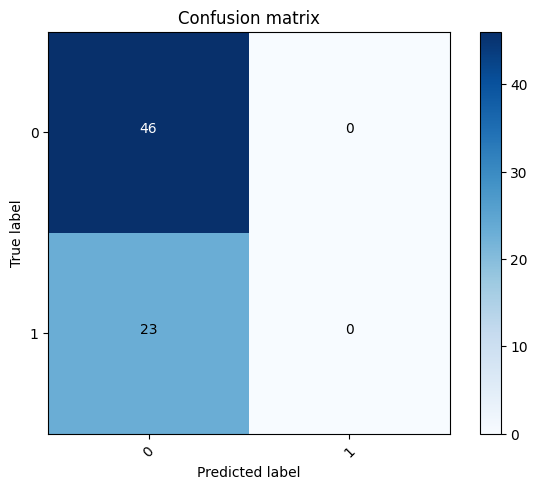

In [18]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = clf.predict(X_test)
confusion_mtx = confusion_matrix(y_test, y_pred) 
plot_confusion_matrix(confusion_mtx, classes = range(2)) 
# Confusion Matrix 

## XGBoost